## CS 445: Computational Photography

## Programming Project #3: Gradient Domain Fusion

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
import scipy.sparse.linalg

# modify to where you store your project data including utils.py
datadir = "C:/Users/jackt/Desktop/CS445/cs445fusion" 

#utilfn = datadir + "utils.py"
#!cp "$utilfn" .
samplesfn = datadir + "samples"
#!cp -r "$samplesfn" .
import utils

## Part 1 Toy Problem (20 pts)

In [2]:
def toy_reconstruct(img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, 
    so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. 
    Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). 
    
    For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    im_h, im_w = img.shape
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)
    neq = (im_h - 1) * im_w + (im_w - 1) * im_h + 1
    
    # construct equation matrix A, solution vector b
    A = scipy.sparse.lil_matrix((neq, im_h*im_w), dtype='double')
    b = np.zeros((neq, 1), dtype='double')
    for e in range(neq):
        if e < (im_h-1) * im_w:
            # vertical edges
            x = e % im_w
            y = e // im_w
            A[e, im2var[y+1][x]] = 1
            A[e, im2var[y][x]] = -1
            b[e] = img[y+1][x] - img[y][x]
        elif e < neq-1:
            # horizontal edges
            temp = e - ((im_h-1)*im_w)
            y = temp % im_h
            x = temp // im_h
            A[e, im2var[y][x+1]] = 1
            A[e, im2var[y][x]] = -1
            b[e] = img[y][x+1] - img[y][x]
        else:
            # objective 3
            x = im_w - 1
            y = im_h - 1
            A[e, im2var[y][x]] = 1
            b[e] = img[y][x]
    
    # solve least squares system
    x = scipy.sparse.linalg.lsqr(A.tocsr(), b)
    return x[0].reshape(im_h, im_w)


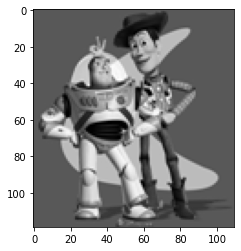

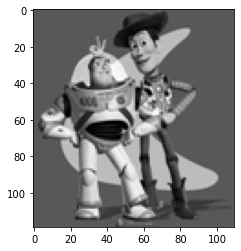

Max error is:  7.5332676048867064e-06


In [3]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

## Preparation

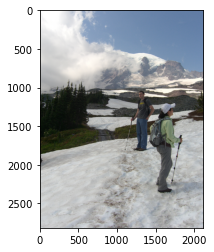

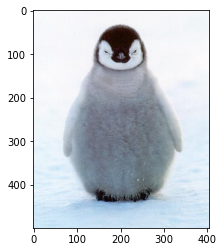

In [2]:
background_img = cv2.cvtColor(cv2.imread('samples/im2.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/penguin-chick.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

use_interface = True  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (65, 359, 359, 65)
  ys = (24, 24, 457, 457)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (500, 2500) # (x,y)

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))



If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


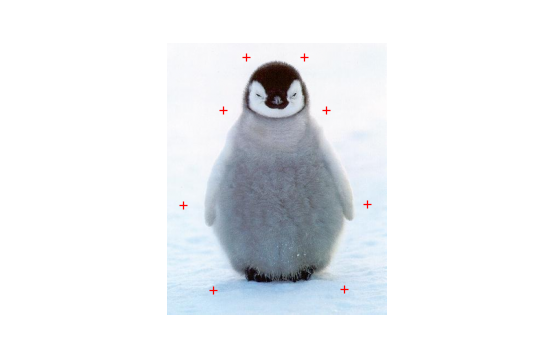

In [4]:
if use_interface:
  import matplotlib.pyplot as plt
  %matplotlib notebook
  mask_coords = utils.specify_mask(object_img)

<Figure size 432x288 with 0 Axes>

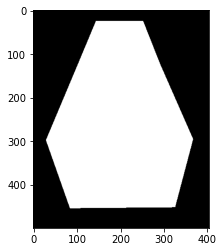

In [6]:
if use_interface:
  xs = mask_coords[0]
  ys = mask_coords[1]
  %matplotlib inline
  import matplotlib.pyplot as plt
  plt.figure()
  object_mask = utils.get_mask(ys, xs, object_img)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


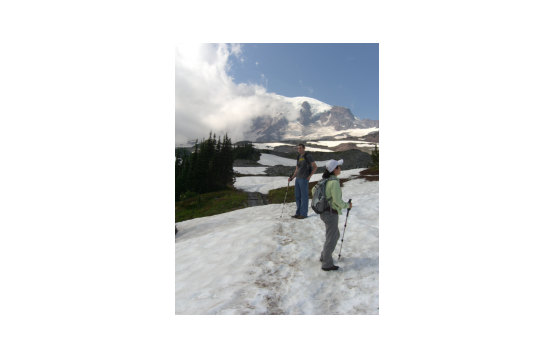

In [8]:
if use_interface:
  %matplotlib notebook
  import matplotlib.pyplot as plt
  bottom_center = utils.specify_bottom_center(background_img)


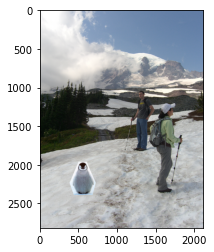

In [9]:
if use_interface:
  %matplotlib inline
  import matplotlib.pyplot as plt

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

## Part 2 Poisson Blending (50 pts)

In [12]:
def combine_img_bw(bg_img, object_img, object_mask, bg_ul):
    combined_img = bg_img.copy()
    (nr, nc) = object_img.shape
    
    combined_patch = combined_img[bg_ul[0]:bg_ul[0]+nr, bg_ul[1]:bg_ul[1]+nc]
    combined_patch = combined_patch*(1-object_mask) + object_img[:,:]*object_mask
    combined_img[bg_ul[0]:bg_ul[0]+nr, bg_ul[1]:bg_ul[1]+nc] =  combined_patch

    return combined_img 

In [17]:
def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    im_h, im_w = object_img.shape
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)
    
    # find neq
    neq = 0
    for y in range(im_h-1):
        for x in range(im_w-1):
            if object_mask[y][x] == 1:
                neq += 2
                continue
            if object_mask[y+1][x] == 1:
                neq += 1
            if object_mask[y][x+1] == 1:
                neq += 1
    
    # construct equation matrix A, solution vector b
    A = scipy.sparse.lil_matrix((neq, im_h*im_w), dtype='double')
    b = np.zeros((neq, 1), dtype='double')
    
    count = 0
    for y in range(im_h-1):
        for x in range(im_w-1):
            # right
            if object_mask[y][x] == 1:
                if object_mask[y][x+1] == 1:
                    A[count, im2var[y][x]] = 1
                    A[count, im2var[y][x+1]] = -1
                    b[count] = object_img[y][x] - object_img[y][x+1]
                    count += 1
                else:
                    A[count, im2var[y][x]] = 1
                    b[count] = object_img[y][x] - object_img[y][x+1] + bg_img[bg_ul[0]+y][bg_ul[1]+x+1]
                    count += 1
            else:
                if object_mask[y][x+1] == 1:
                    A[count, im2var[y][x+1]] = 1
                    b[count] = object_img[y][x+1] - object_img[y][x] + bg_img[bg_ul[0]+y][bg_ul[1]+x]
                    count += 1
            # down
            if object_mask[y][x] == 1:
                if object_mask[y+1][x] == 1:
                    A[count, im2var[y][x]] = 1
                    A[count, im2var[y+1][x]] = -1
                    b[count] = object_img[y][x] - object_img[y+1][x]
                    count += 1
                else:
                    A[count, im2var[y][x]] = 1
                    b[count] = object_img[y][x] - object_img[y+1][x] + bg_img[bg_ul[0]+y+1][bg_ul[1]+x]
                    count += 1
            else:
                if object_mask[y+1][x] == 1:
                    A[count, im2var[y+1][x]] = 1
                    b[count] = object_img[y+1][x] - object_img[y][x] + bg_img[bg_ul[0]+y][bg_ul[1]+x]
                    count += 1
            if count >= neq:
                break
        if count >= neq:
            break
    
    # solve least squares system
    v = scipy.sparse.linalg.lsqr(A.tocsr(), b)
    blend = v[0].reshape(im_h, im_w)
    plt.imshow(blend)
    plt.show()
    
    return combine_img_bw(bg_img, blend, object_mask, bg_ul)


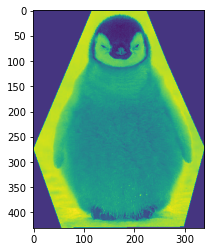

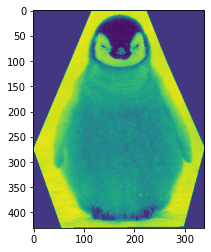

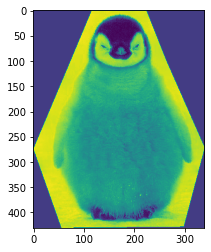

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


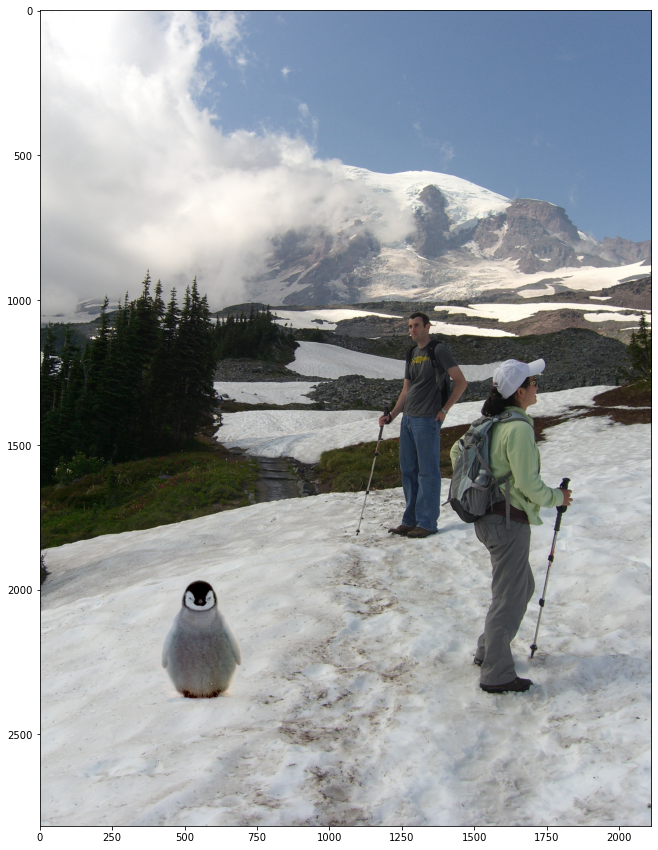

In [18]:
im_blend = np.zeros(background_img.shape)
for b in np.arange(3):
  im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_blend)

## Part 3 Mixed Gradients (20 pts)

In [ ]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO 



In [ ]:
im_mix = np.zeros(background_img.shape)
for b in np.arange(3):
  im_mix[:,:,b] = mixed_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_mix)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [ ]:
def color2gray(img):
    pass

## Laplacian pyramid blending (20 pts)

In [ ]:
def laplacian_blend(object_img, object_mask, bg_img, bg_ul):
  # feel free to change input parameters
    pass

## More gradient domain processing (up to 20 pts)